In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
import mlflow
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [2]:
data = pd.read_csv("train.csv", parse_dates=['date'])
warnings.filterwarnings('ignore')

In [3]:
data["id"] = data["id"].fillna("no_project")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


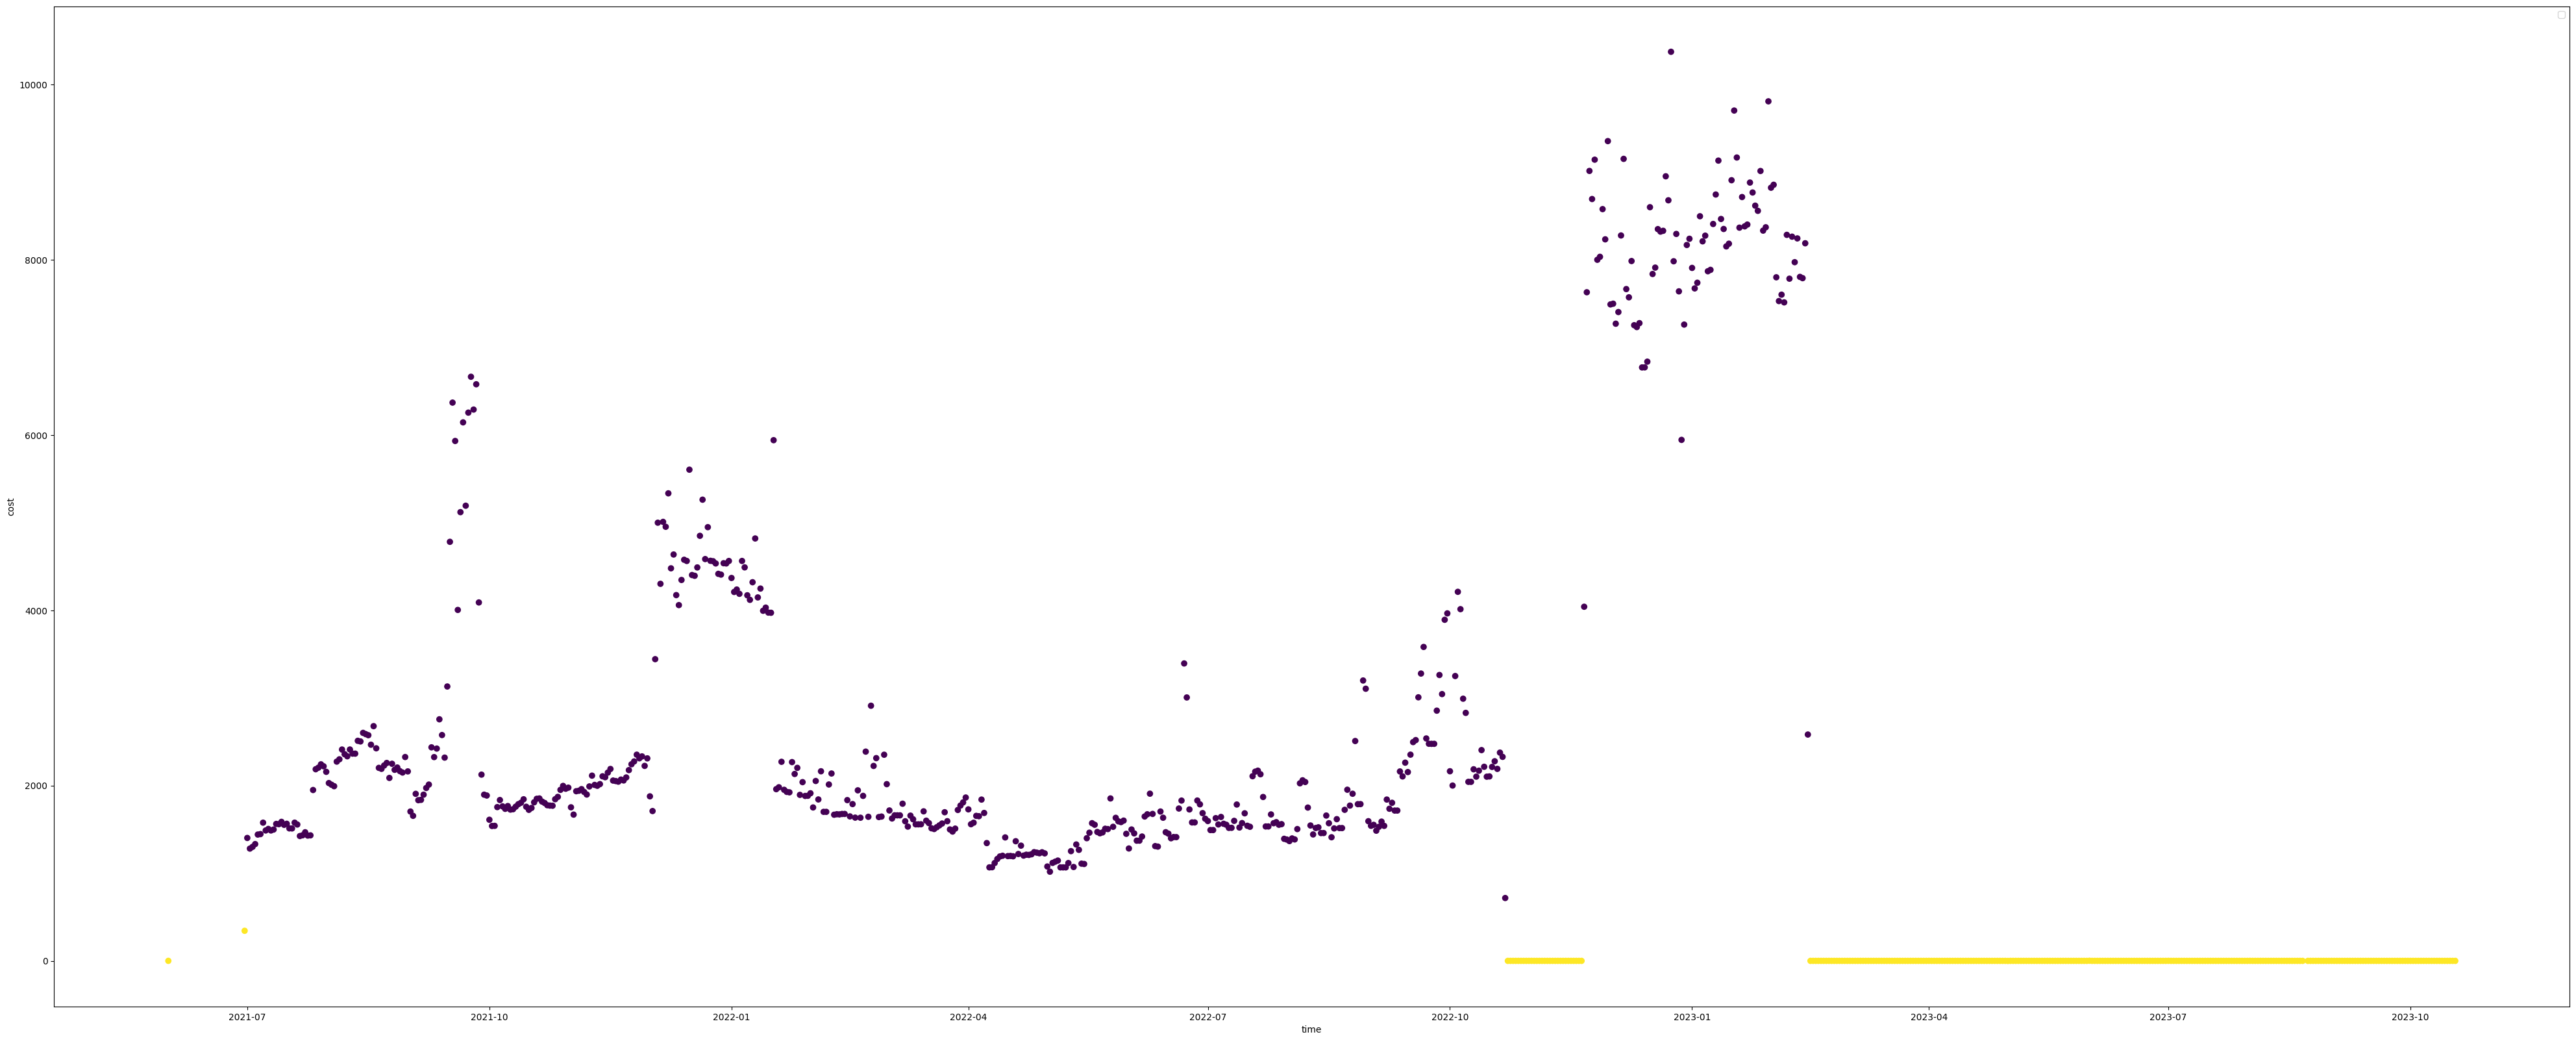

In [4]:
cluster = AgglomerativeClustering(n_clusters=2, linkage='single')
y = data.groupby(data['date'])['cost_for_date'].sum().sort_index()
y = y[y.values >= -5]
x = np.arange(0, 1 * (len(y)), 1)

# Create a 2D array with x and y values
data_2d = pd.DataFrame({
    'x': x,
    'y': y.values*100
})

cluster.fit(data_2d)
data_2d
plt.figure(figsize=[50, 20])
plt.scatter(y.index, data_2d['y'], c=cluster.labels_)
plt.xlabel('time')
plt.ylabel('cost')
plt.legend()
plt.show()

resultFromClustering = pd.DataFrame({
    'date': y.index,
    'has_promotions': cluster.labels_,
    'cost': y.values
})

In [5]:
# depends on data so if the bigger cluster has more data the result is reverse
bad_data_for_date = resultFromClustering[abs(resultFromClustering['has_promotions']) == 1].get('date')

In [6]:
bad_data_for_date

0     2021-06-01 00:00:00+00:00
1     2021-06-30 00:00:00+00:00
481   2022-10-23 00:00:00+00:00
482   2022-10-24 00:00:00+00:00
483   2022-10-25 00:00:00+00:00
                 ...           
836   2023-10-14 00:00:00+00:00
837   2023-10-15 00:00:00+00:00
838   2023-10-16 00:00:00+00:00
839   2023-10-17 00:00:00+00:00
840   2023-10-18 00:00:00+00:00
Name: date, Length: 276, dtype: datetime64[ns, UTC]

In [7]:
bad_data_for_date = pd.DataFrame({
    "date" : bad_data_for_date.values
})
bad_data_for_date['date'] = pd.to_datetime(bad_data_for_date['date'])

# Calculate the difference between consecutive dates
bad_data_for_date['date_diff'] = bad_data_for_date['date'].diff()

# Create a mask where the date sequence is broken
mask = bad_data_for_date['date_diff'] > pd.Timedelta(days=1)

# Create a new DataFrame with from_date and to_date columns
new_df = pd.DataFrame(columns=['from_date', 'to_date'])

# Initialize variables to keep track of date ranges
from_date = None

for index, row in bad_data_for_date.iterrows():
    if from_date is None:
        from_date = row['date']
    elif mask.iloc[index]:
        to_date = bad_data_for_date.loc[index - 1, 'date']
        new_df = pd.concat([new_df, pd.DataFrame({'from_date': [from_date], 'to_date': [to_date]})], ignore_index=True)
        from_date = row['date']

# Add the last date range
to_date = bad_data_for_date['date'].iloc[-1]

if (to_date - from_date) >= pd.Timedelta(days=10):
    new_df = pd.concat([new_df, pd.DataFrame({'from_date': [from_date], 'to_date': [to_date]})], ignore_index=True)

print(new_df)

   from_date    to_date
0 2021-06-01 2021-06-01
1 2021-06-30 2021-06-30
2 2022-10-23 2022-11-20
3 2023-02-15 2023-08-21
4 2023-08-23 2023-10-18


In [8]:
periods_without_data= new_df[(new_df['to_date'] - new_df['from_date']).dt.days >= 10]

In [9]:
def splitToTrainAndTest(data, period_from, period_to) :
    
    cutoff_date_start = pd.to_datetime(period_from).tz_localize('UTC')
    train = data[data['date'] < cutoff_date_start]
    
    cutoff_date_end = pd.to_datetime(period_to).tz_localize('UTC')
    test = data[(data['date'] >= cutoff_date_start) & (data['date'] <= cutoff_date_end)]
    
    data_attr_train = train.drop(columns=['cost_for_date'])
    data_target_train = train.get("cost_for_date")
    data_attr_test = test.drop(columns=['cost_for_date'])
    data_target_test = test.get("cost_for_date")
    return data_attr_train, data_attr_test, data_target_train, data_target_test

In [10]:
def concatenate_columns(row):
    return f"{row['year']}-{row['month']}-{row['day']}"

In [11]:
def plotColumnsWithDetails(attributes, actual_target, predicted_target) : 
    dataframeRes = attributes.assign(date=attributes.apply(concatenate_columns, axis=1))
    dataframeRes['predicted_target'] = predicted_target
    dataframeRes['actual_target'] = actual_target
    daily_costs_pred = dataframeRes.groupby(dataframeRes['date'])['predicted_target'].sum()
    daily_costs_act = dataframeRes.groupby(dataframeRes['date'])['actual_target'].sum()
    daily_costs_pred.index = pd.to_datetime(daily_costs_pred.index)
    daily_costs_act.index = pd.to_datetime(daily_costs_act.index)

    daily_costs_pred = daily_costs_pred.sort_index()
    daily_costs_act = daily_costs_act.sort_index()
    fig, ax = plt.subplots(figsize=(30, 15))

    ax.plot(daily_costs_pred.index, daily_costs_pred.values, marker='o', linestyle='-', color='red')
    ax.plot(daily_costs_act.index, daily_costs_act.values, marker='o', linestyle='-', color='blue')

    print('RMSE: ', round(mean_squared_error(y_true=daily_costs_act.values,y_pred=daily_costs_pred.values),3))
    print('MAE: ', round(mean_absolute_error(y_true=daily_costs_act.values,y_pred=daily_costs_pred.values),3))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true = daily_costs_act.values,y_pred =daily_costs_pred.values),3))
    plt.grid(True)
    plt.show()

In [12]:
allColumnsDistinct = pd.get_dummies(data.drop(columns=['cost_for_date', 'date'])).columns.tolist()

{'max_depth': 5, 'n_estimators': 30, 'reg_lambda': 10}
RMSE:  13.915
MAE:  2.019
MAPE:  1.775


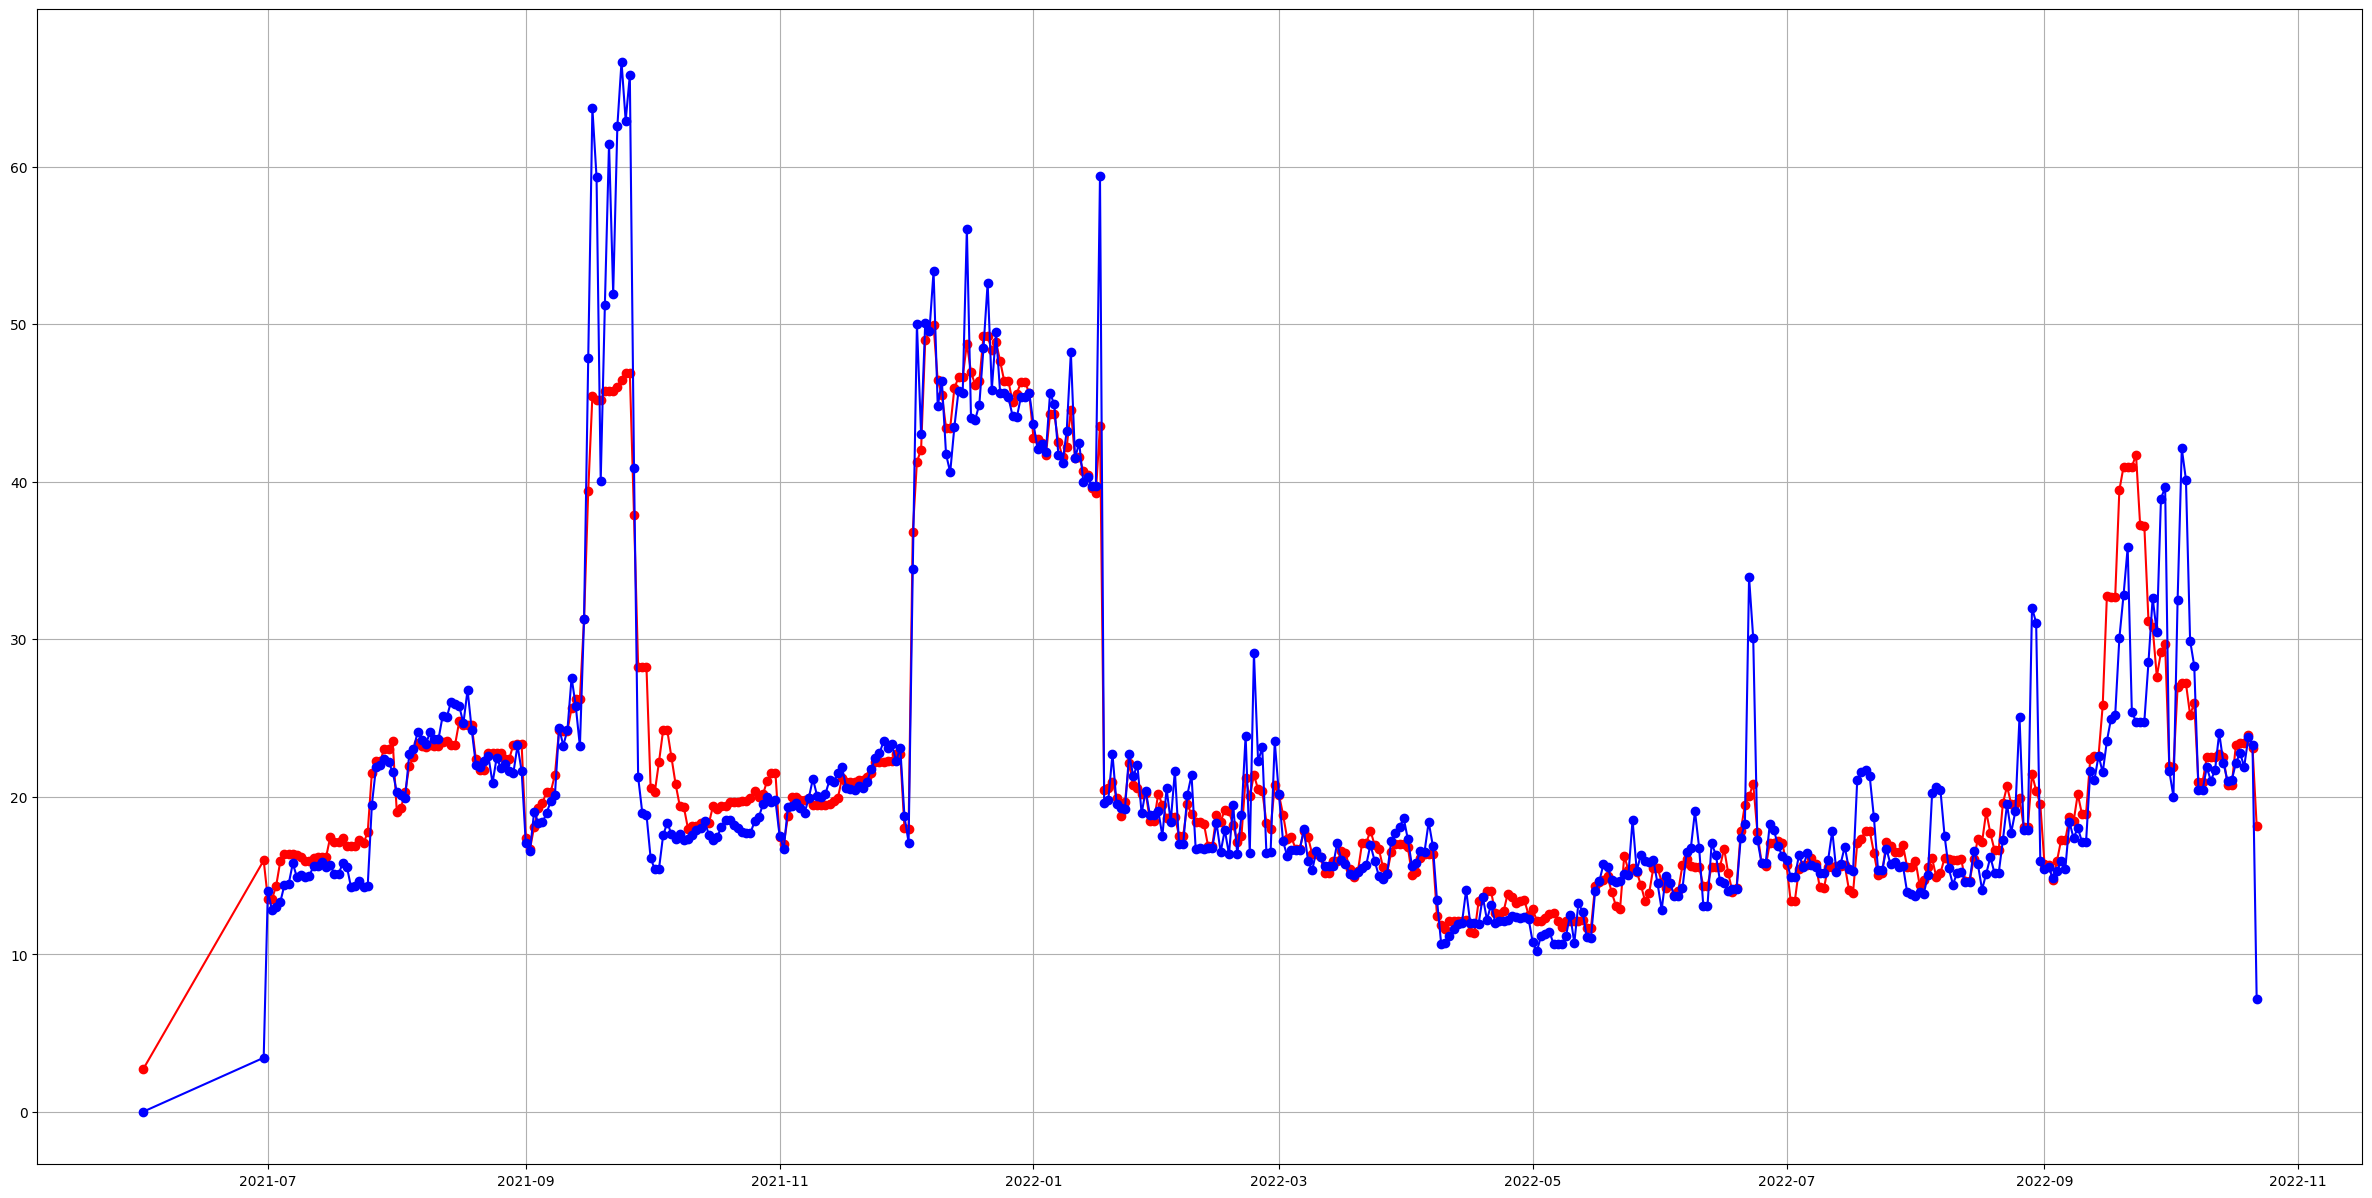

RMSE:  1078.243
MAE:  32.484
MAPE:  415795.331


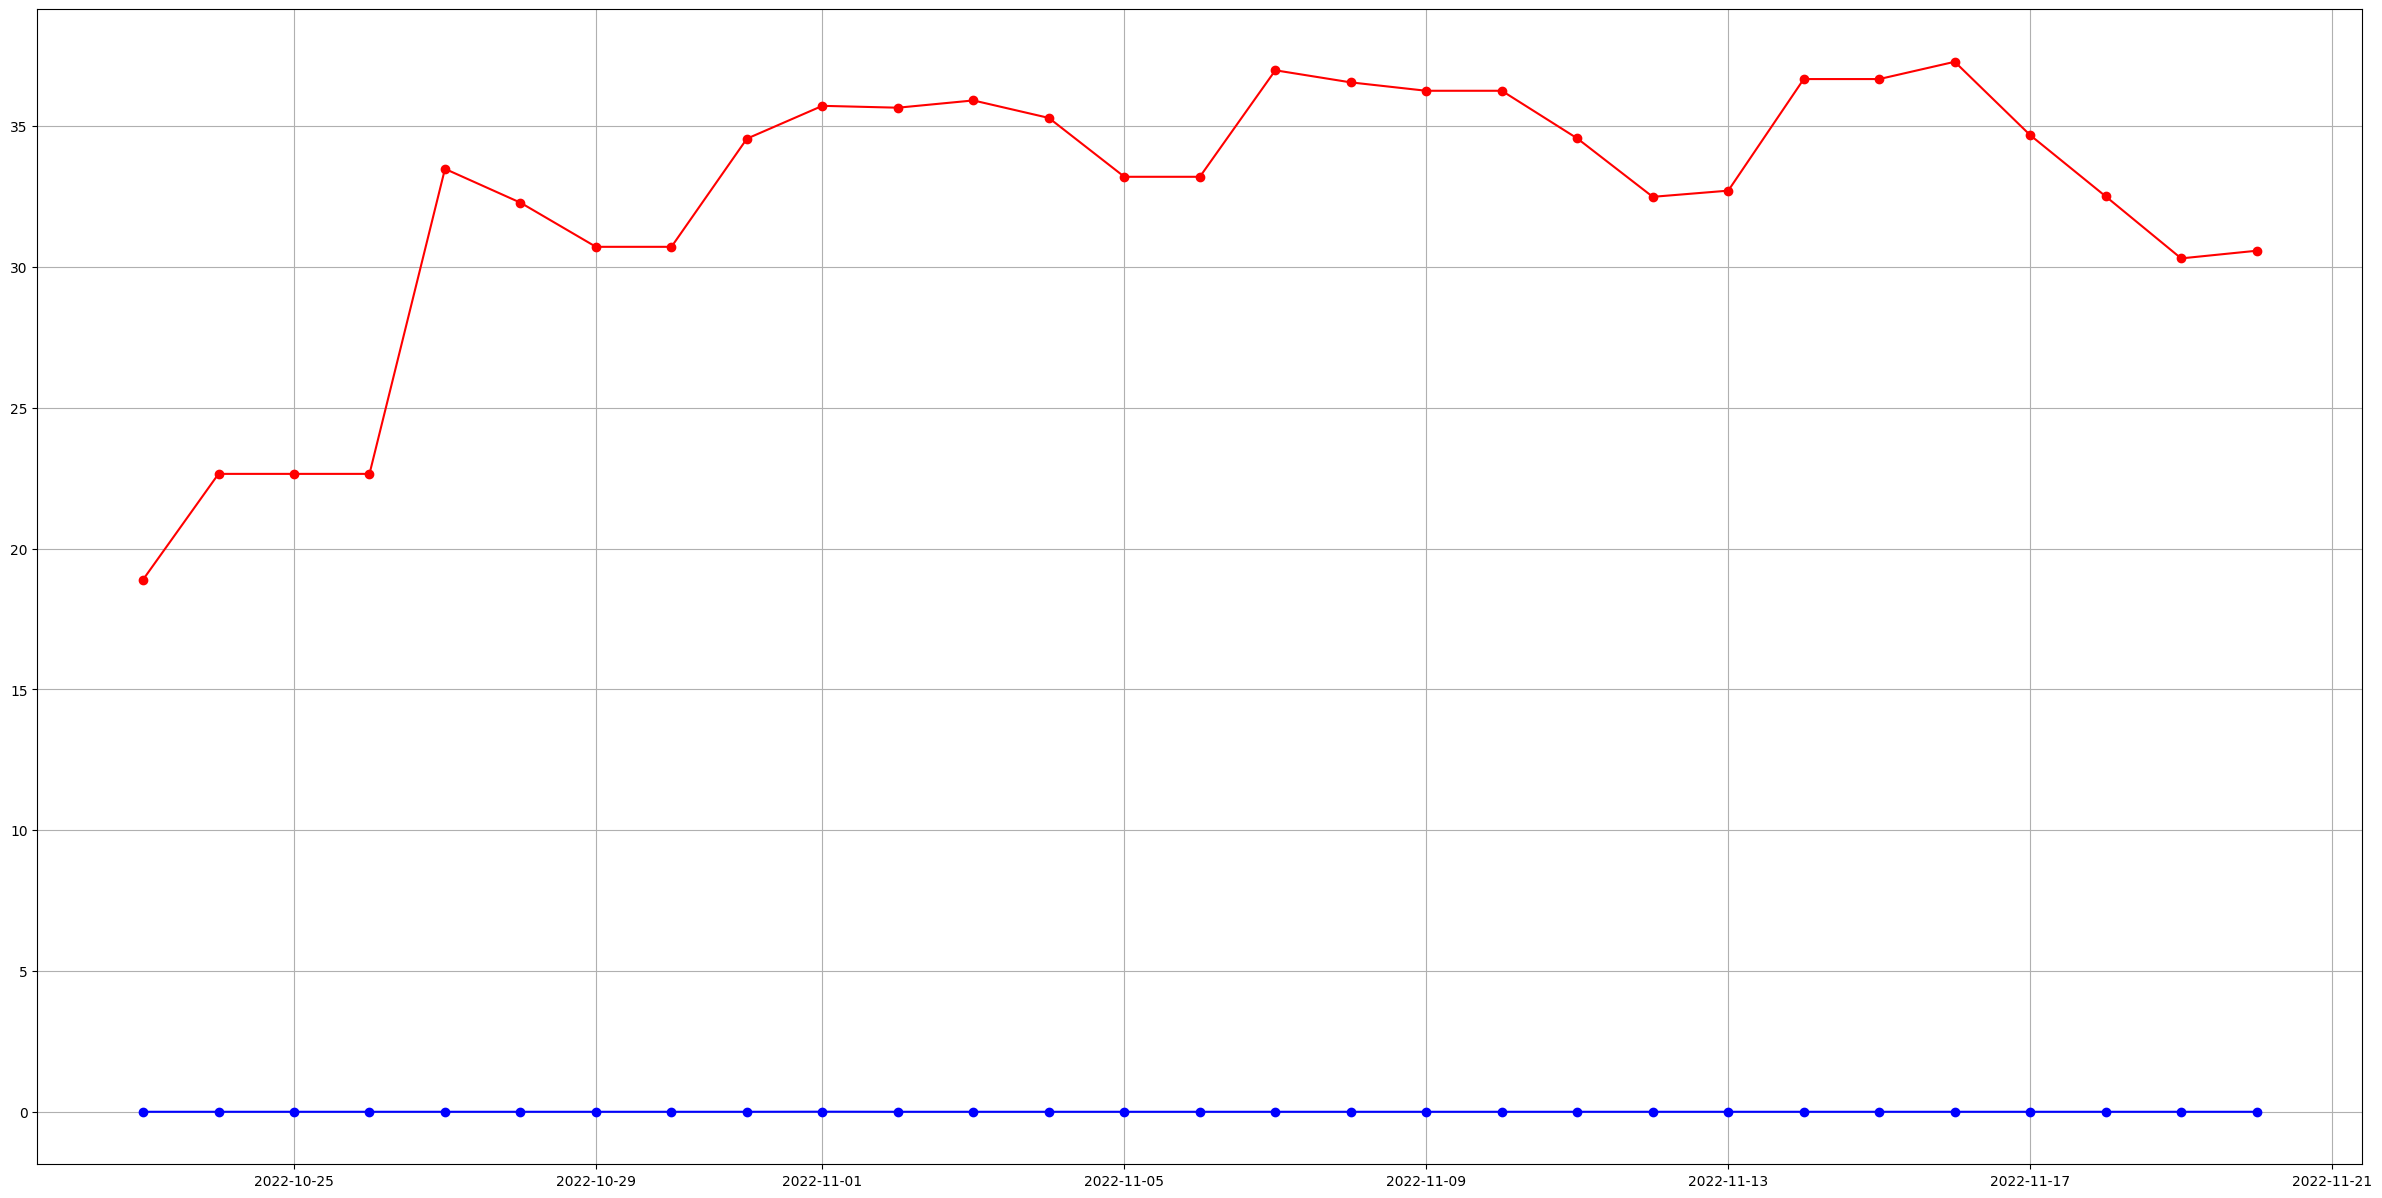

{'max_depth': 5, 'n_estimators': 30, 'reg_lambda': 10}
RMSE:  14.892
MAE:  2.207
MAPE:  1.411


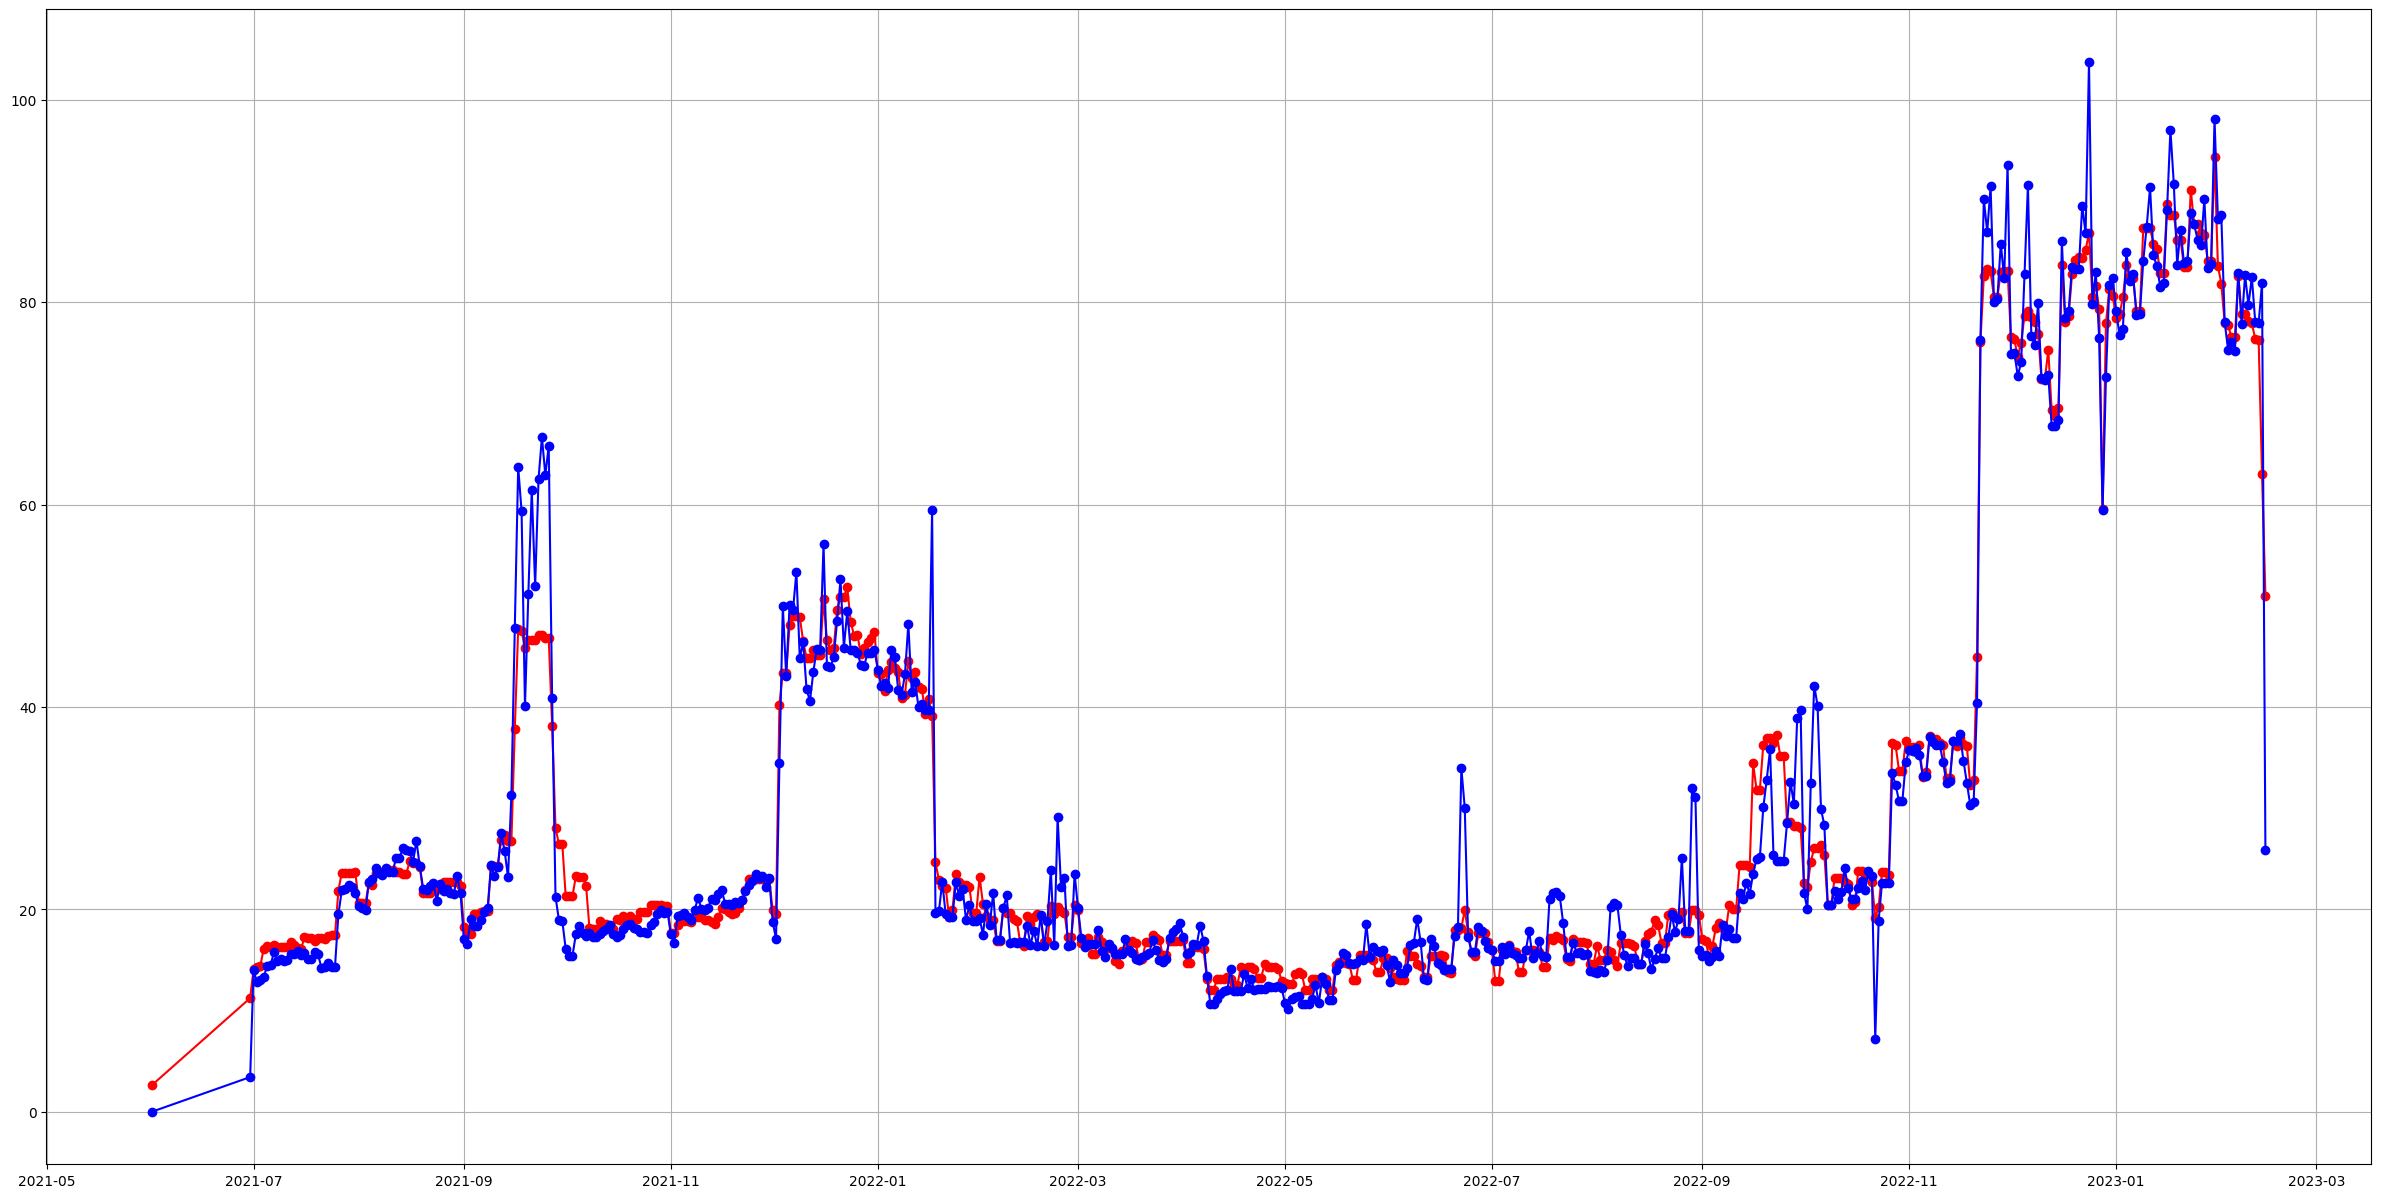

RMSE:  3003.593
MAE:  54.629
MAPE:  139600.438


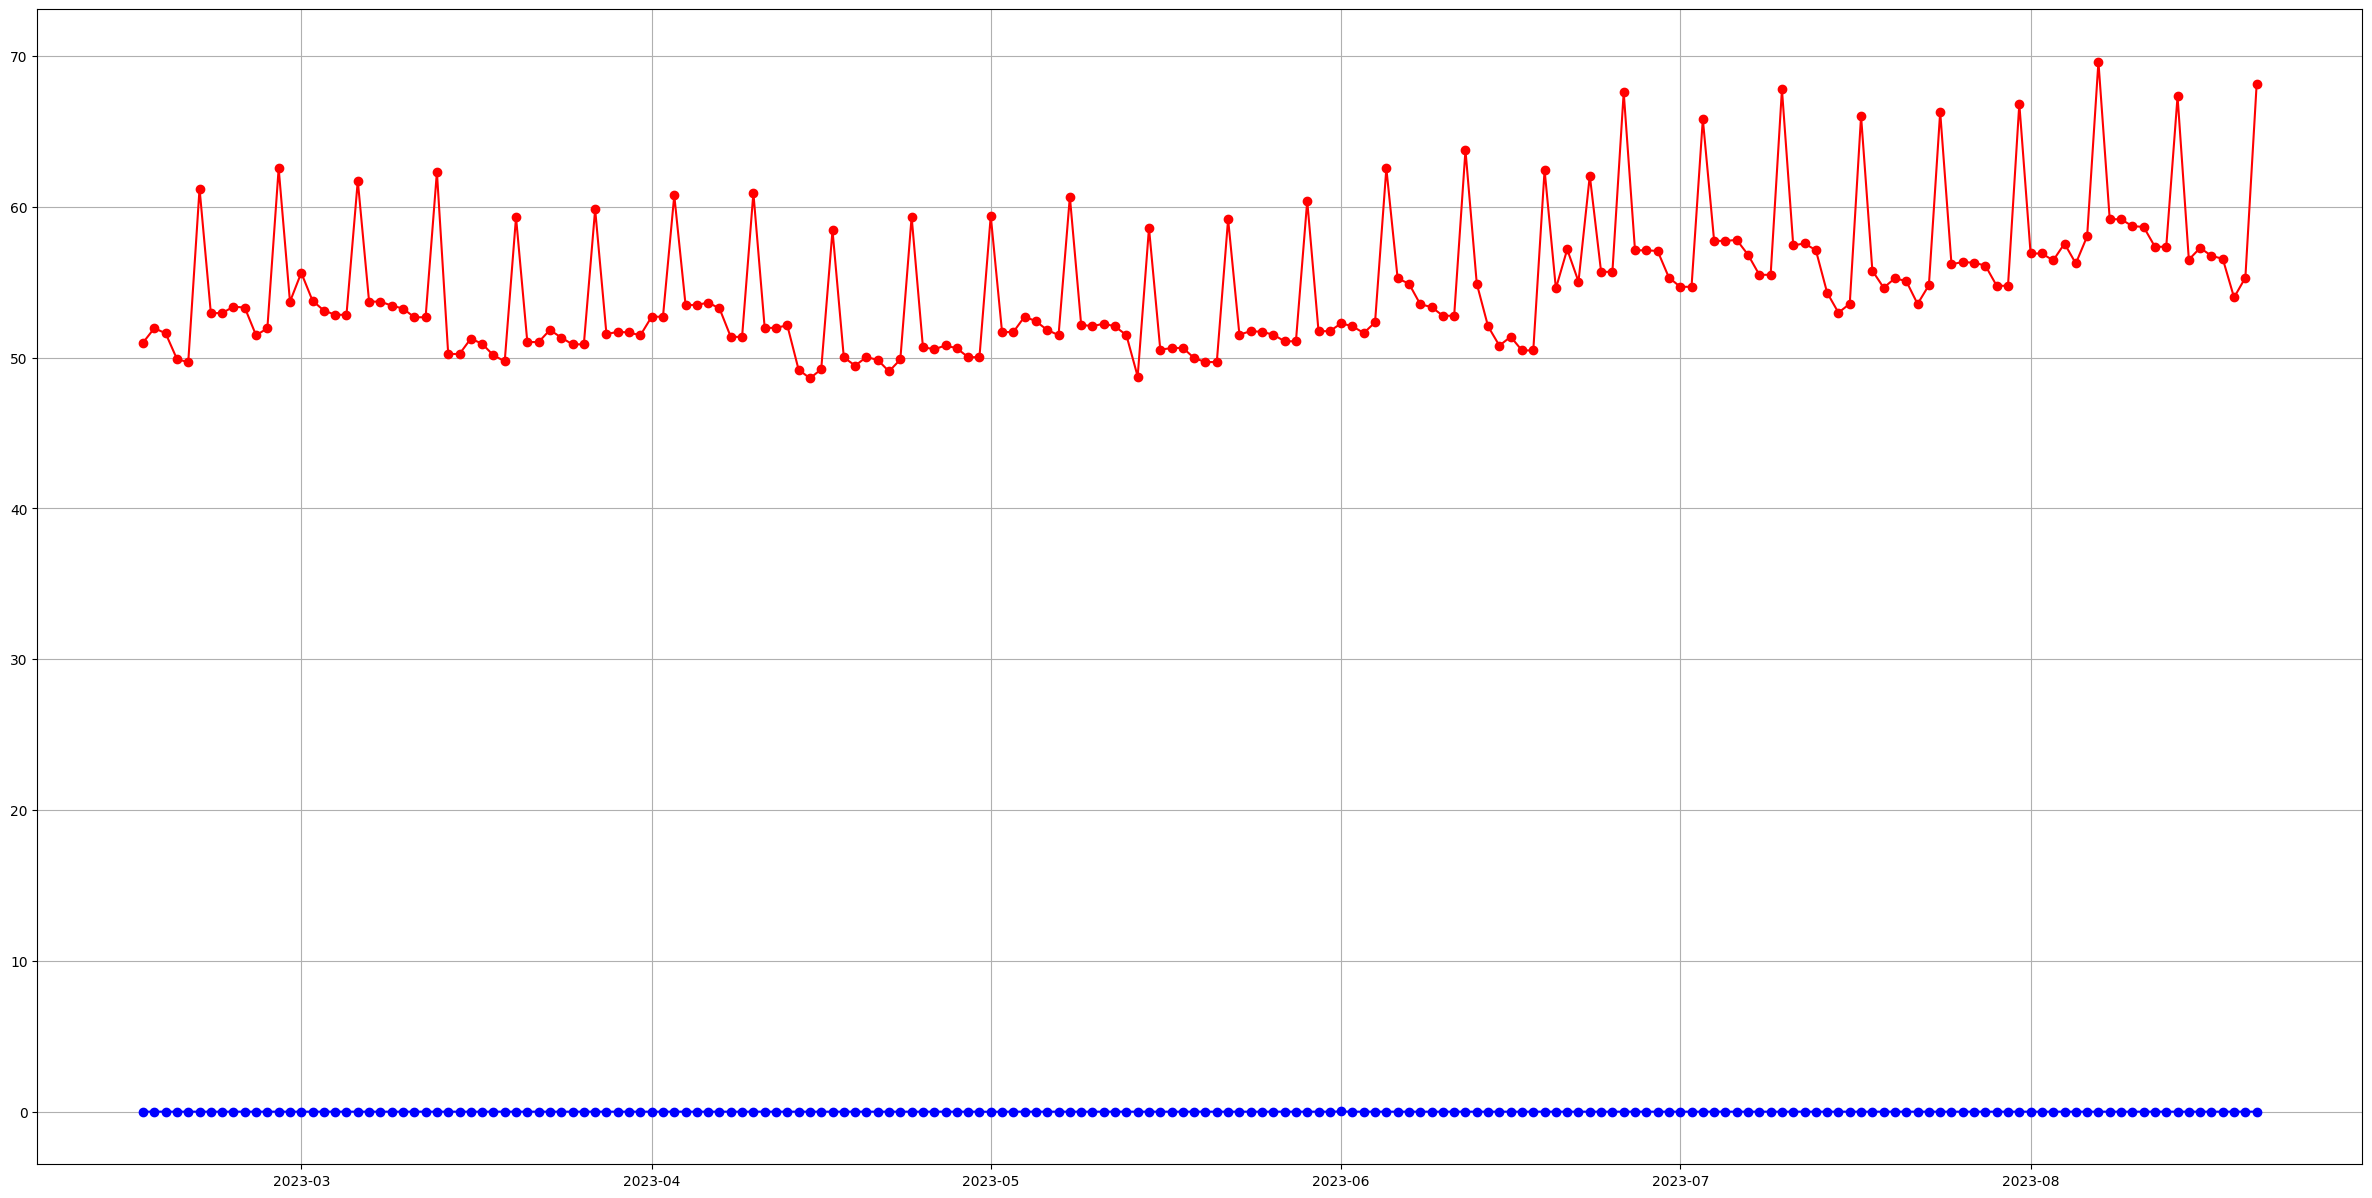

{'max_depth': 5, 'n_estimators': 30, 'reg_lambda': 500}
RMSE:  105.777
MAE:  5.723
MAPE:  1.027


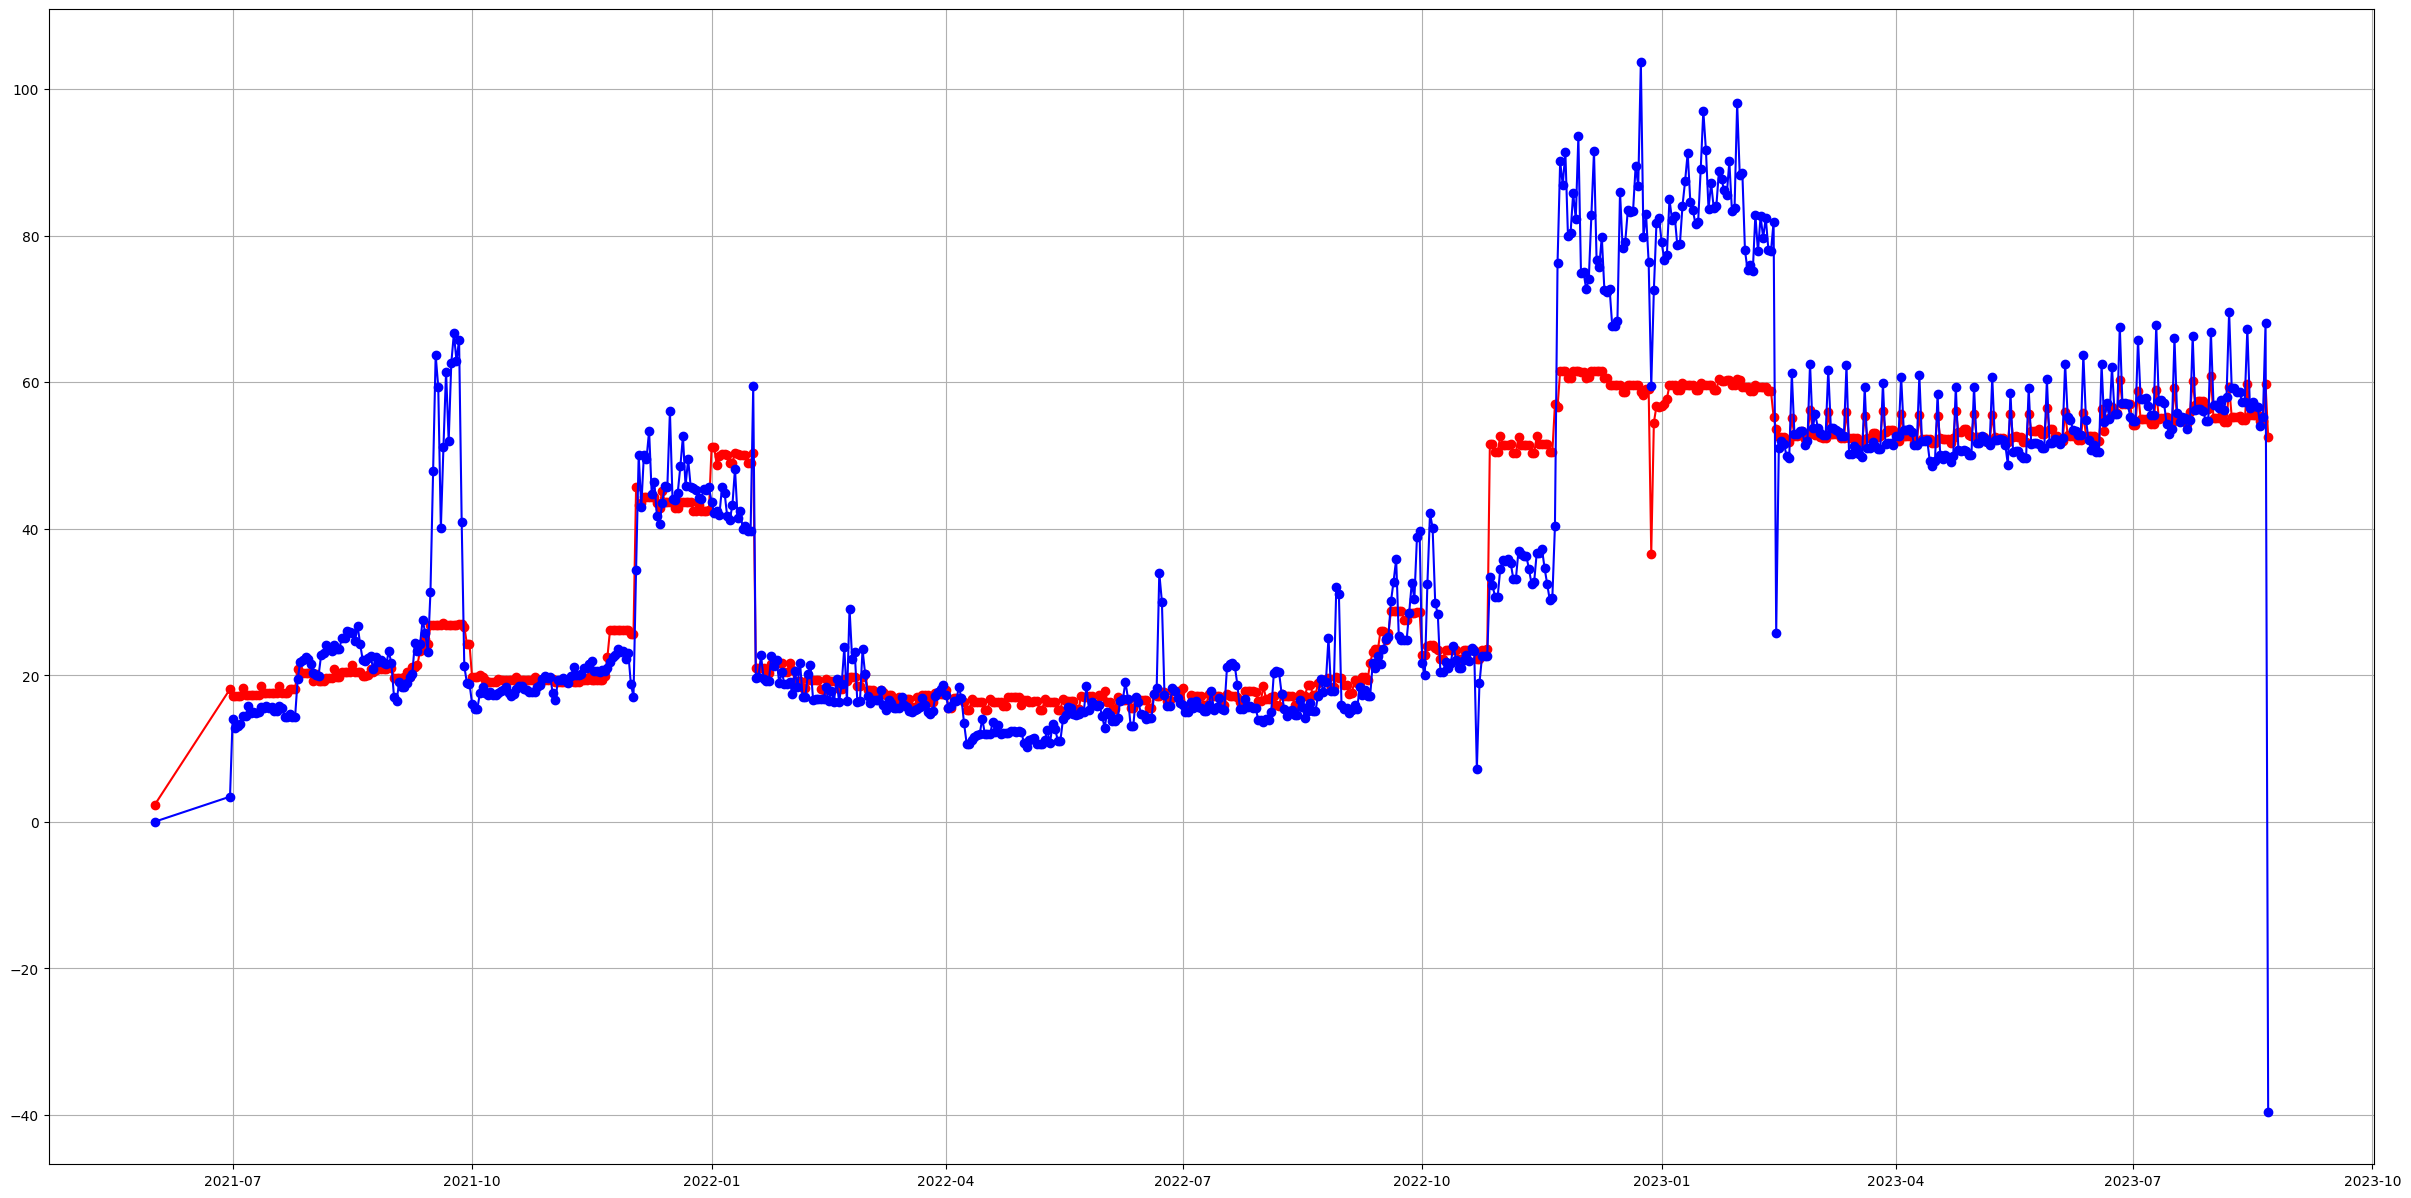

RMSE:  3215.946
MAE:  56.487
MAPE:  4075973695237919.0


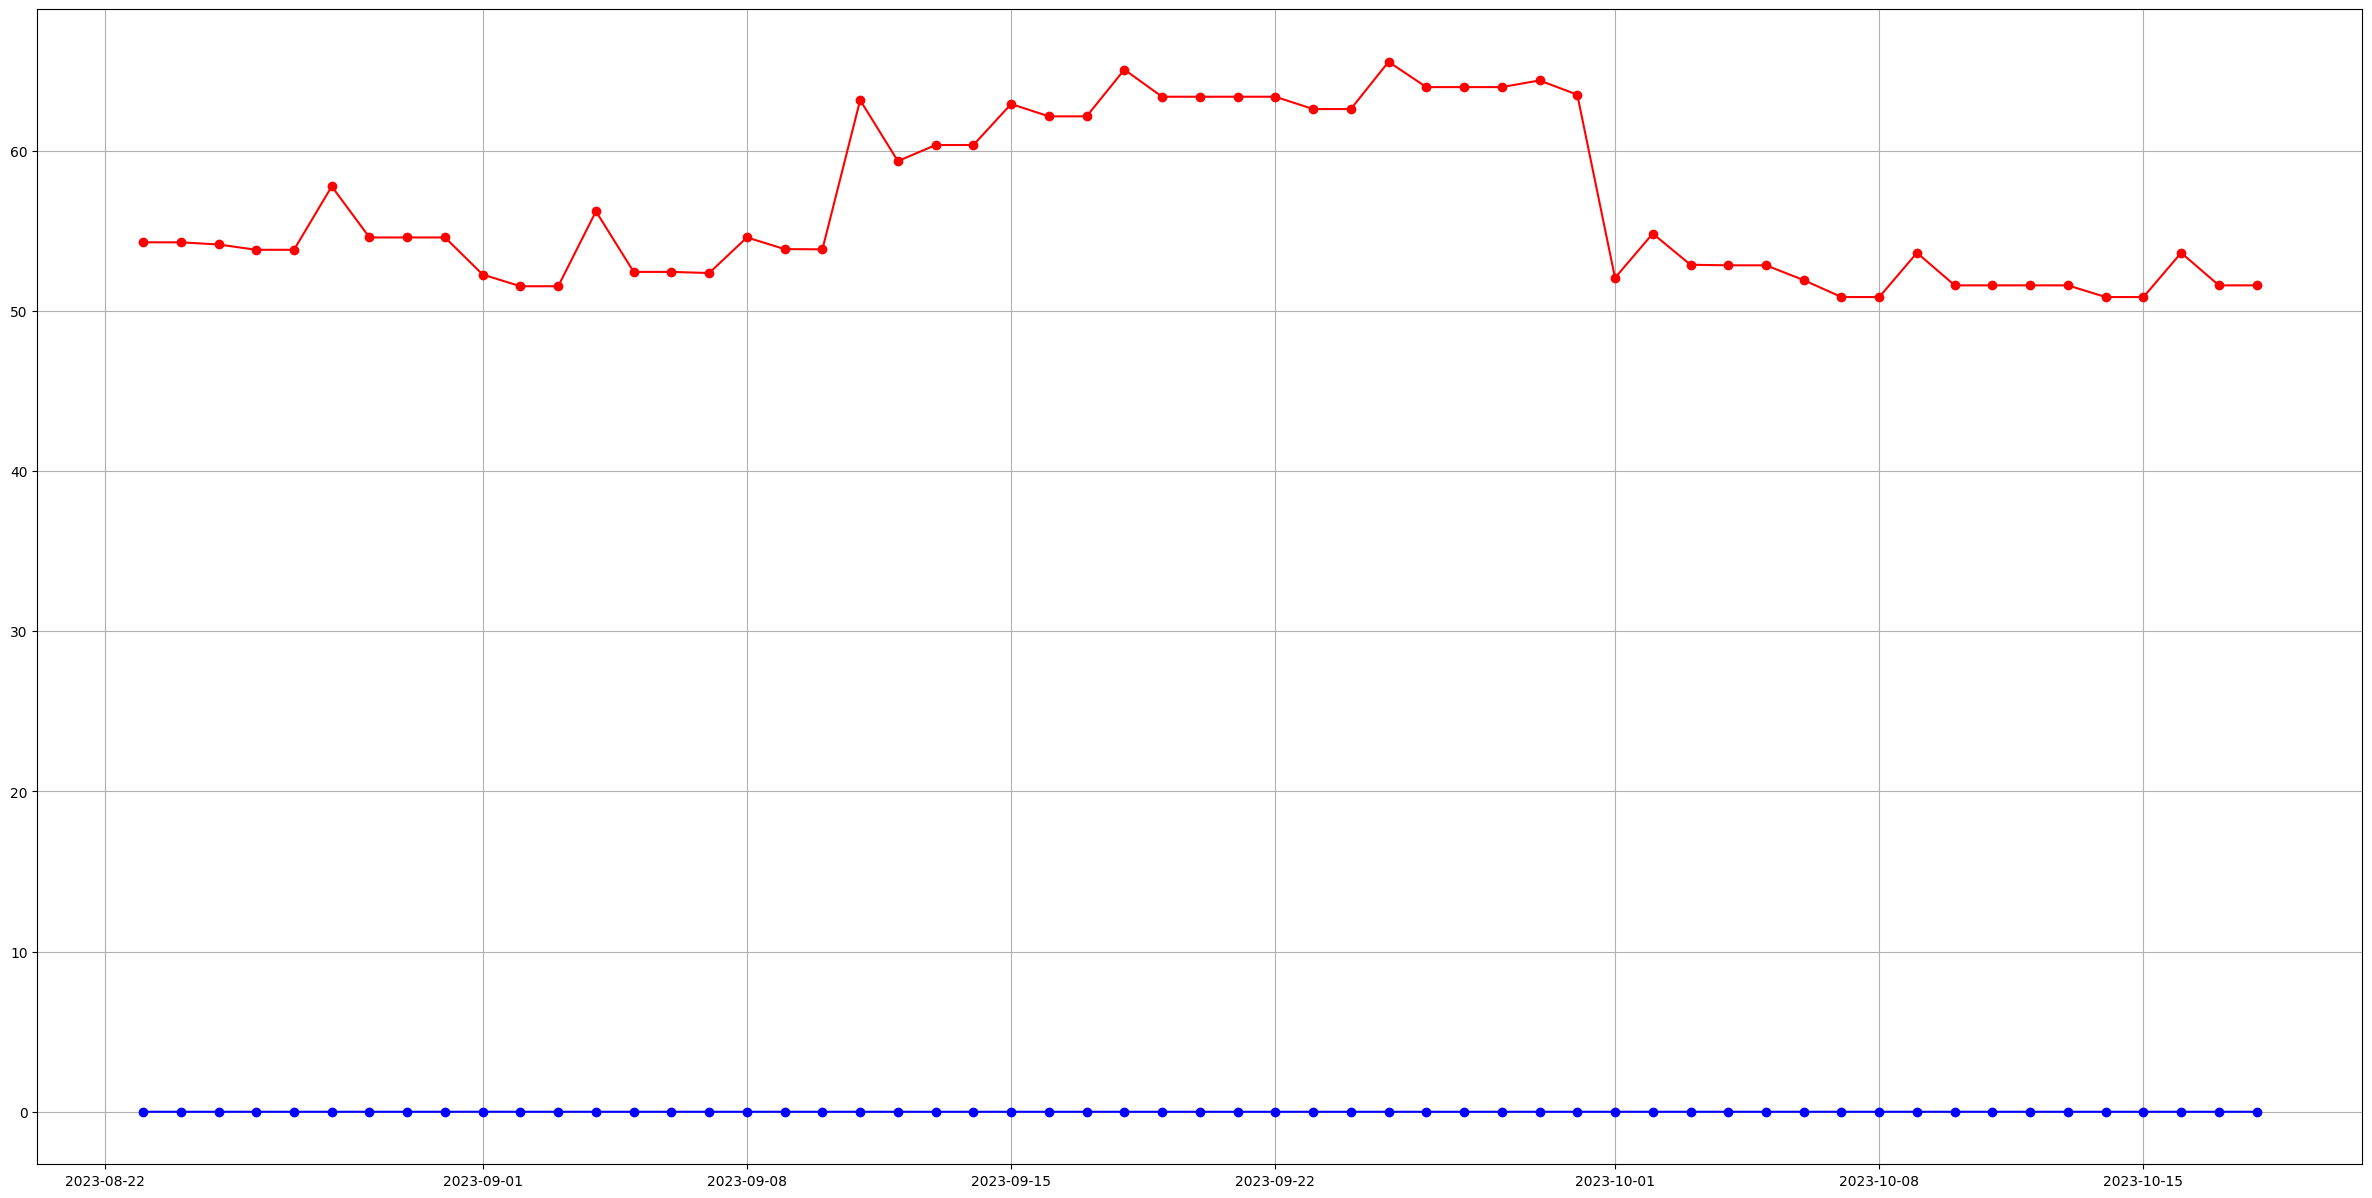

In [13]:
for index, row in periods_without_data.iterrows():
    attr_train, attr_test, target_train, target_test = splitToTrainAndTest(data, row['from_date'], row['to_date'])
    attr_train['year'] = attr_train['date'].dt.year
    attr_train['weekofyear'] = attr_train['date'].dt.isocalendar().week
    attr_train['dayofyear'] = attr_train['date'].dt.dayofyear
    attr_train['quarter'] = attr_train['date'].dt.quarter
    attr_train['month'] = attr_train['date'].dt.month
    attr_train['dayofweek'] = attr_train['date'].dt.dayofweek
    attr_train['day'] = attr_train['date'].dt.day
    attr_train = attr_train.drop(columns=['date'])
    attr_train = pd.get_dummies(attr_train)
    for category in allColumnsDistinct:
        if category not in attr_train.columns:
            attr_train[category] = 0
    param_grid = {
        'n_estimators': [30, 50, 70],
        'max_depth': [4, 5],
        'reg_lambda': [10, 100, 500],
    }
    model = xgb.XGBRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
    grid_search.fit(attr_train, target_train)
    best_params = grid_search.best_params_
    print(best_params)
    # data_log = np.log(attr_train)
    # seasonal_decompose(data_log)
    # model = ARIMA(data_log)
    model = xgb.XGBRegressor(**best_params)
    model.fit(attr_train, target_train)
    predicted_train = np.clip(model.predict(attr_train), a_min=0, a_max=None)

    plotColumnsWithDetails(attr_train, target_train, predicted_train)
    
    attr_test['year'] = attr_test['date'].dt.year
    attr_test['weekofyear'] = attr_test['date'].dt.isocalendar().week
    attr_test['dayofyear'] = attr_test['date'].dt.dayofyear
    attr_test['quarter'] = attr_test['date'].dt.quarter
    attr_test['month'] = attr_test['date'].dt.month
    attr_test['dayofweek'] = attr_test['date'].dt.dayofweek
    attr_test['day'] = attr_test['date'].dt.day
    attr_test = attr_test.drop(columns=['date'])
    attr_test = pd.get_dummies(attr_test)
    for category in allColumnsDistinct:
        if category not in attr_test.columns:
            attr_test[category] = 0

    attr_test = attr_test.reindex(columns=attr_train.columns)
    predicted_test = np.clip(model.predict(attr_test), a_min=0, a_max=None)
    plotColumnsWithDetails(attr_test, target_test, predicted_test)

    mask = (data['date'] >= row['from_date'].tz_localize('UTC')) & (data['date'] <= row['to_date'].tz_localize('UTC'))
    data.loc[mask, 'cost_for_date'] = predicted_test

{'max_depth': 6, 'n_estimators': 50, 'reg_lambda': 500}
RMSE:  53.326
MAE:  4.185
MAPE:  1.189


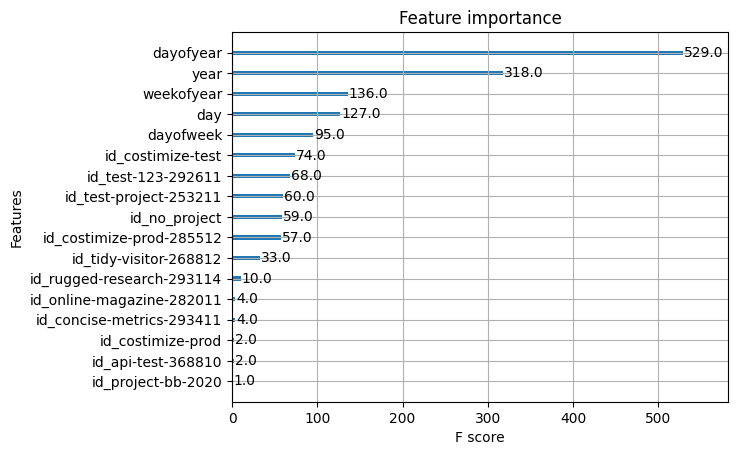

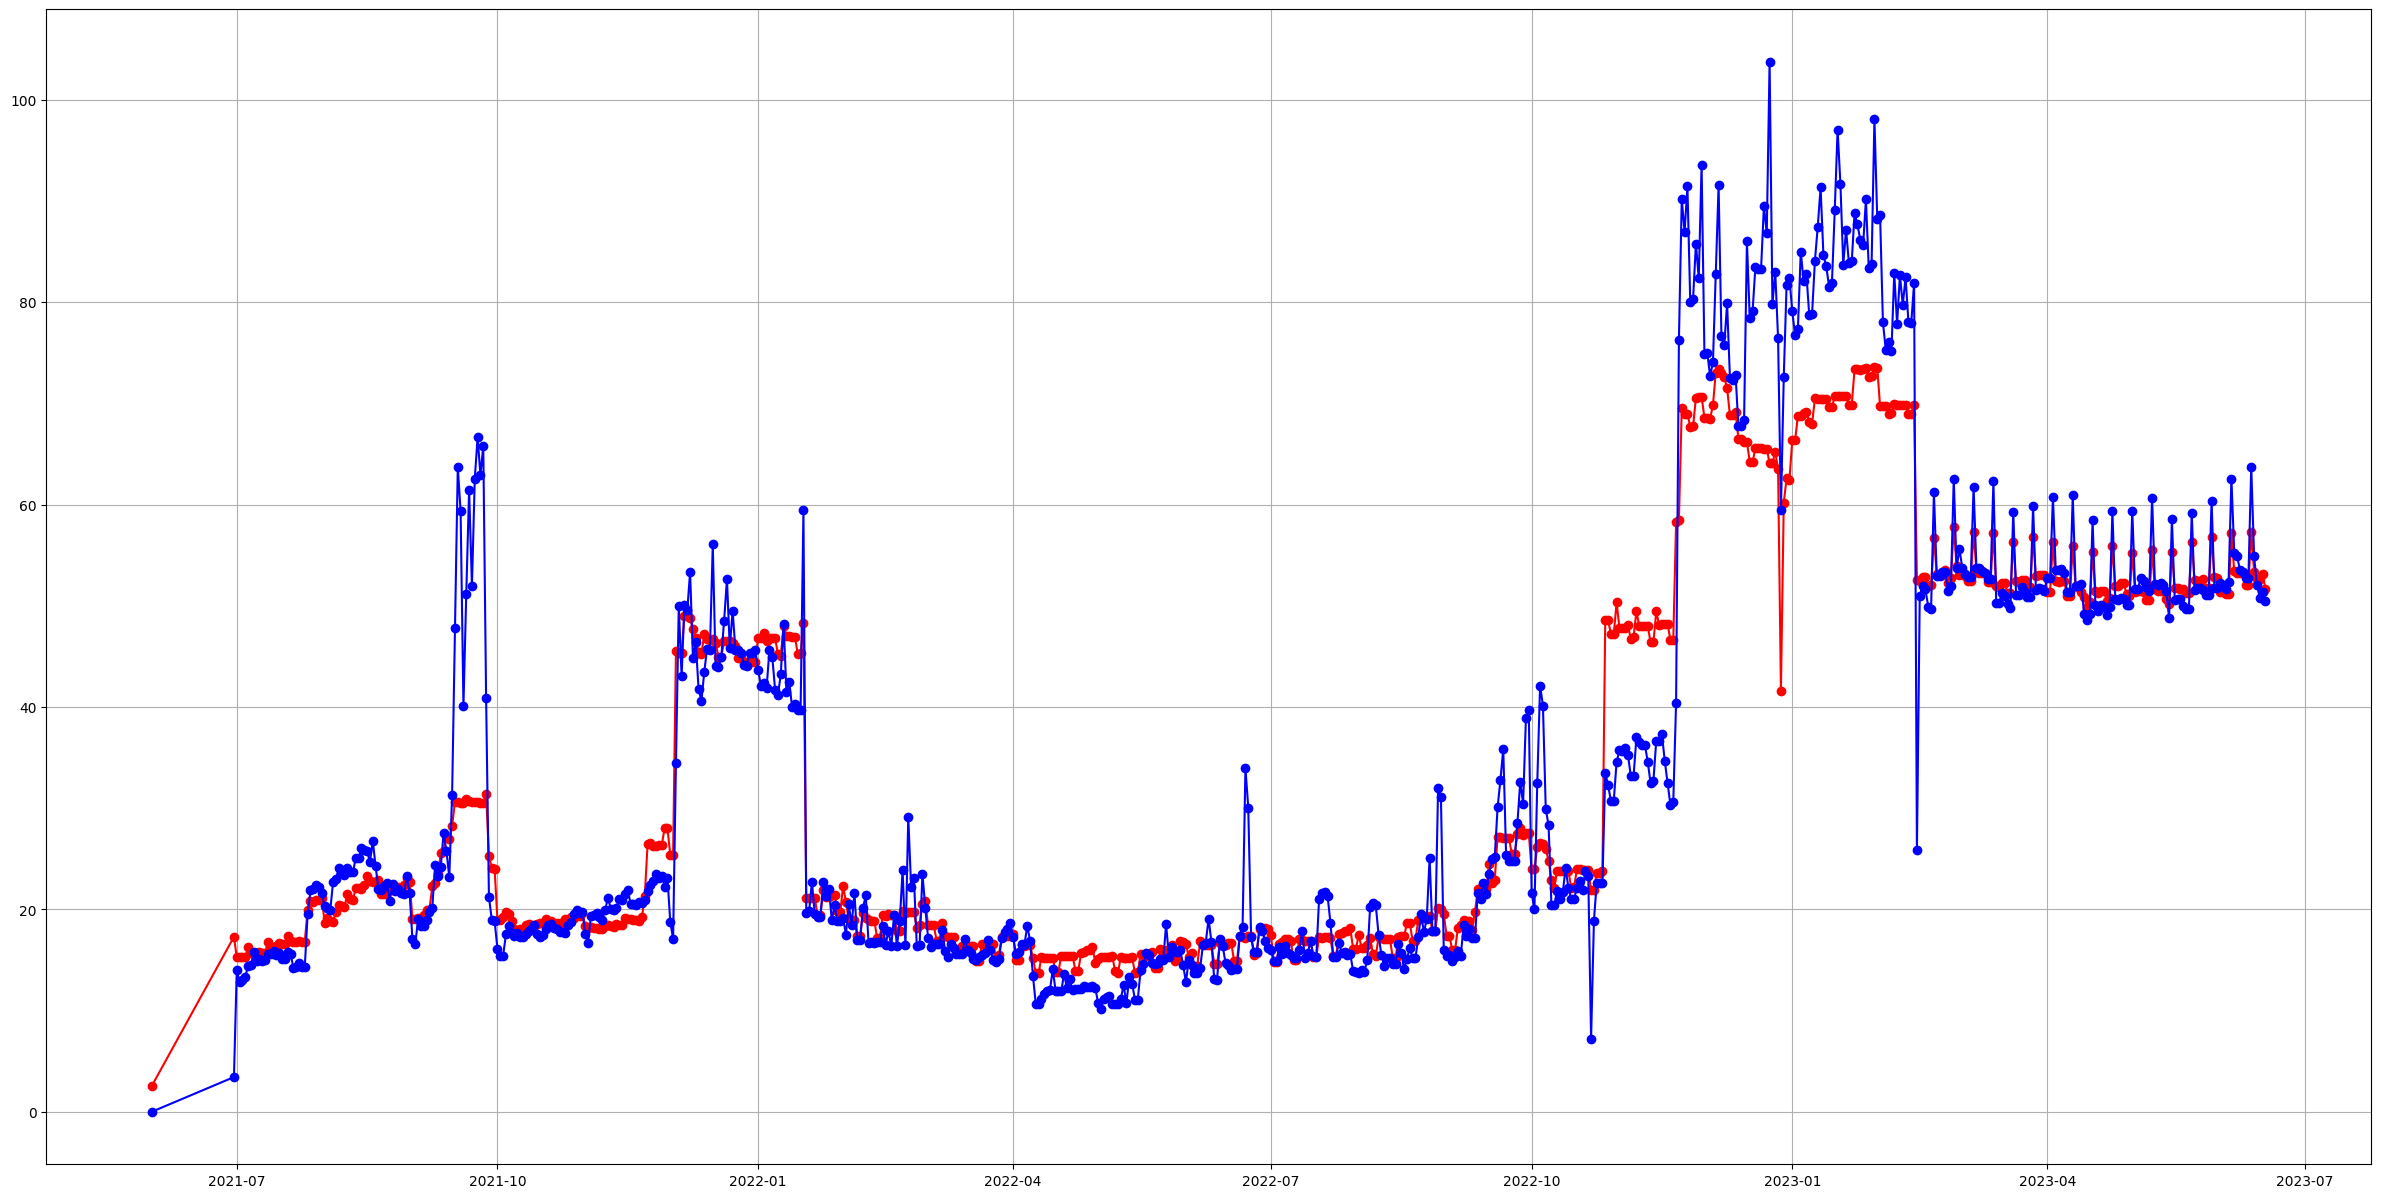

RMSE:  85.048
MAE:  3.009
MAPE:  0.058


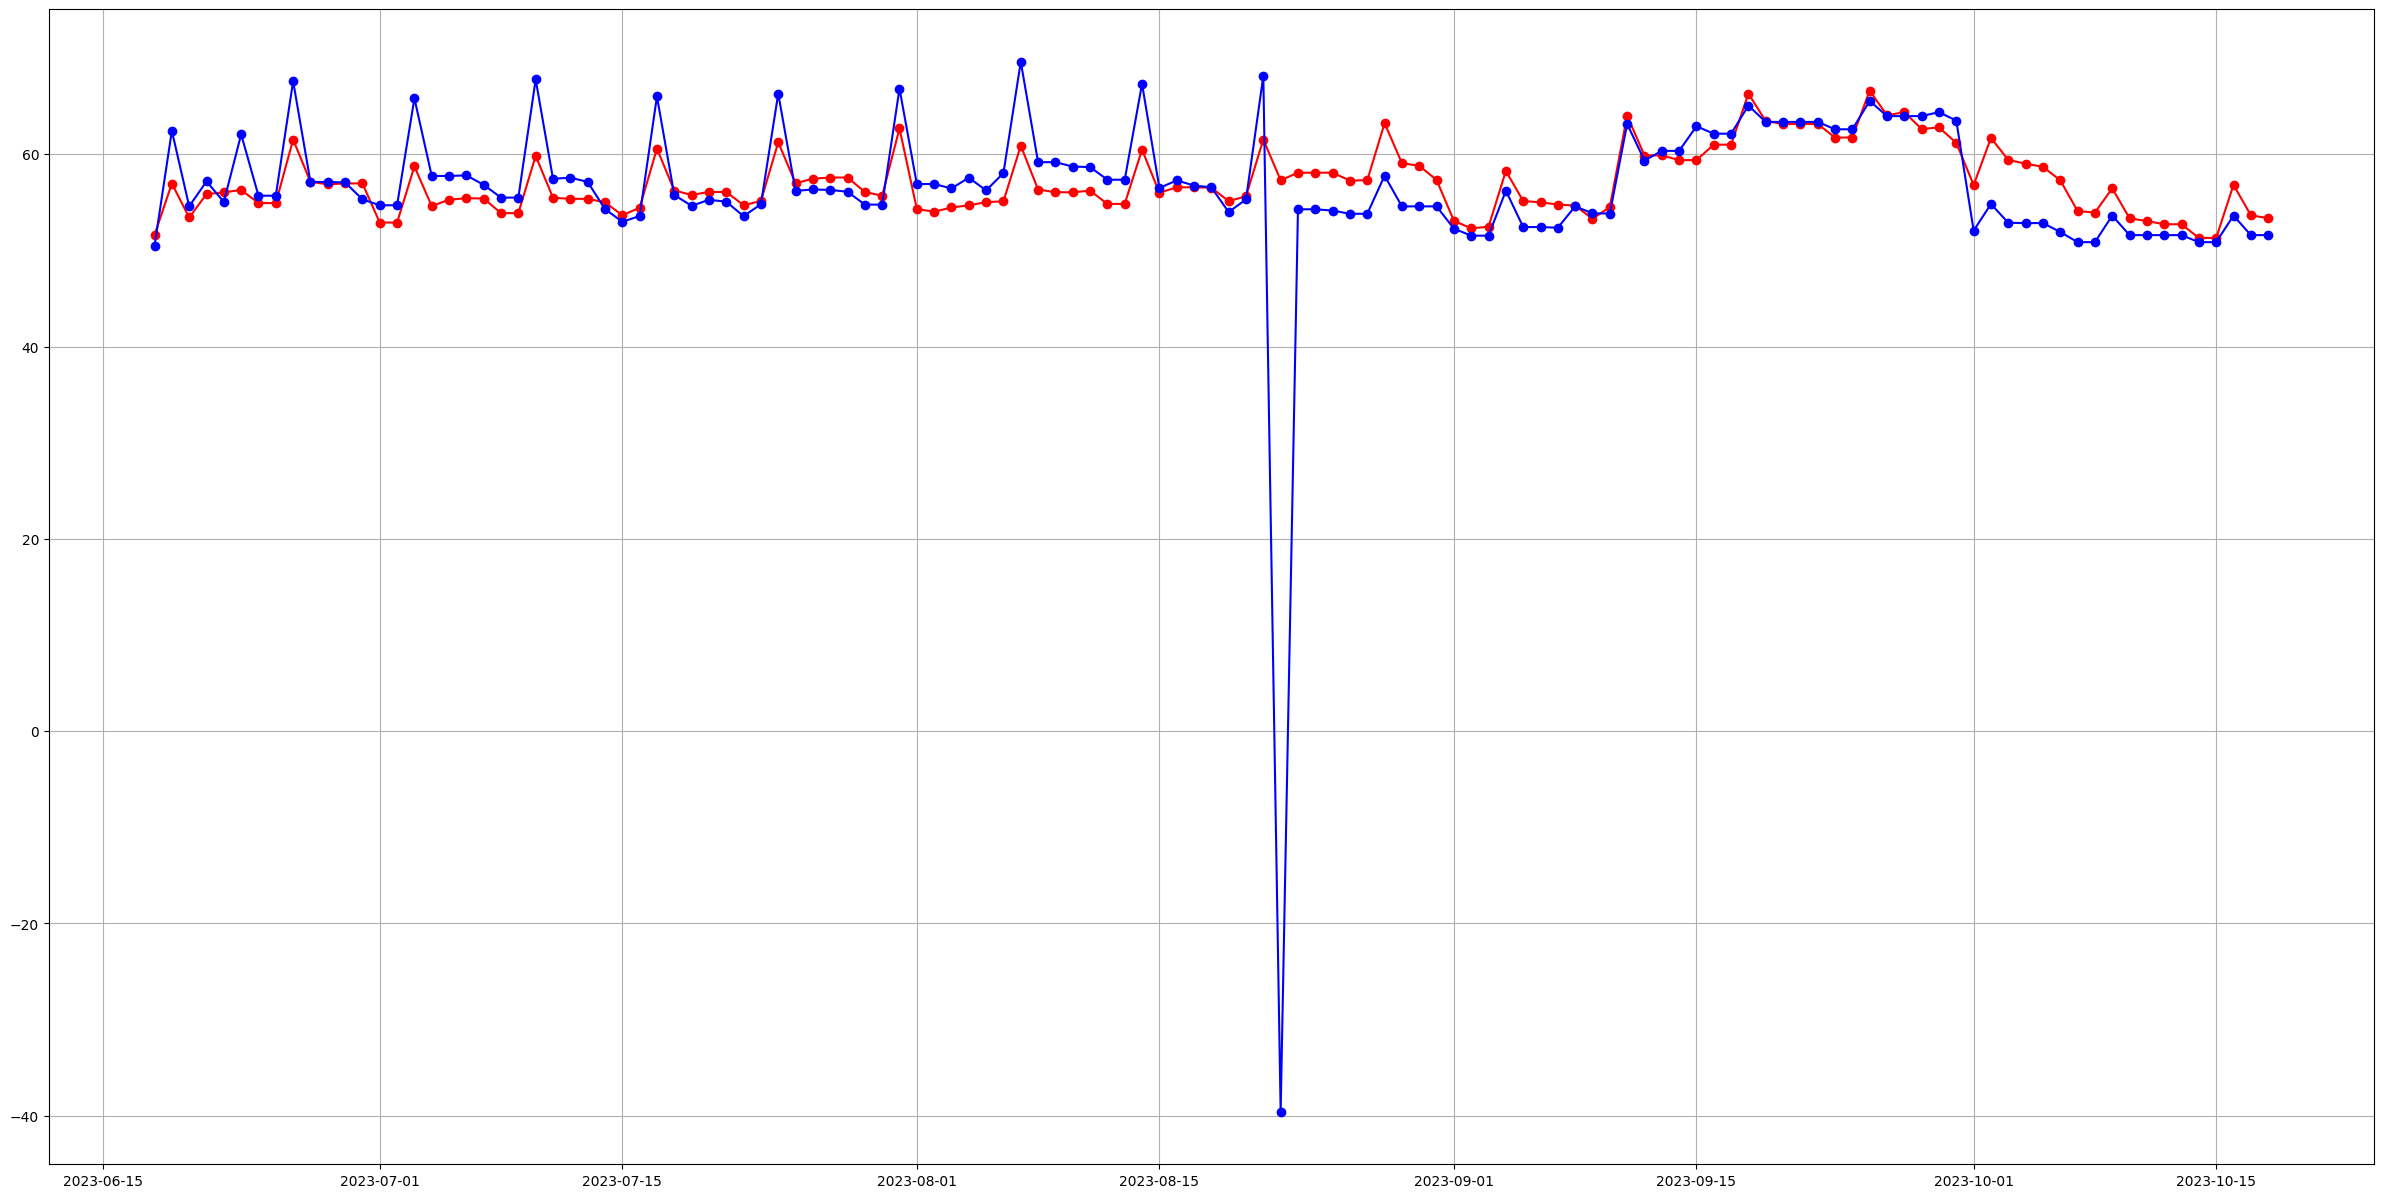

In [14]:
    attr_train, attr_test, target_train, target_test = splitToTrainAndTest(data, '2023-6-18 00:00:00.000000', '2023-10-18 00:00:00.000000')
    attr_train['year'] = attr_train['date'].dt.year
    attr_train['weekofyear'] = attr_train['date'].dt.isocalendar().week
    attr_train['dayofyear'] = attr_train['date'].dt.dayofyear
    attr_train['quarter'] = attr_train['date'].dt.quarter
    attr_train['month'] = attr_train['date'].dt.month
    attr_train['dayofweek'] = attr_train['date'].dt.dayofweek
    attr_train['day'] = attr_train['date'].dt.day
    attr_train = attr_train.drop(columns=['date'])
    attr_train = pd.get_dummies(attr_train)
    for category in allColumnsDistinct:
        if category not in attr_train.columns:
            attr_train[category] = 0
    param_grid = {
        'n_estimators': [50, 70],
        'max_depth': [3, 4, 5, 6],
        'reg_lambda': [1, 10, 100, 500],
    }
    model = xgb.XGBRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
    grid_search.fit(attr_train, target_train)
    best_params = grid_search.best_params_
    print(best_params)
    # data_log = np.log(attr_train)
    # seasonal_decompose(data_log)
    # model = ARIMA(data_log)
    model = xgb.XGBRegressor(**best_params)
    model.fit(attr_train, target_train)
    predicted_train = np.clip(model.predict(attr_train), a_min=0, a_max=None)
    xgb.plot_importance(model)
    plotColumnsWithDetails(attr_train, target_train, predicted_train)
    
    attr_test['year'] = attr_test['date'].dt.year
    attr_test['weekofyear'] = attr_test['date'].dt.isocalendar().week
    attr_test['dayofyear'] = attr_test['date'].dt.dayofyear
    attr_test['quarter'] = attr_test['date'].dt.quarter
    attr_test['month'] = attr_test['date'].dt.month
    attr_test['dayofweek'] = attr_test['date'].dt.dayofweek
    attr_test['day'] = attr_test['date'].dt.day
    attr_test = attr_test.drop(columns=['date'])
    attr_test = pd.get_dummies(attr_test)
    for category in allColumnsDistinct:
        if category not in attr_test.columns:
            attr_test[category] = 0

    attr_test = attr_test.reindex(columns=attr_train.columns)
    predicted_test = np.clip(model.predict(attr_test), a_min=0, a_max=None)
    plotColumnsWithDetails(attr_test, target_test, predicted_test)